## Imports and Functions

In [1]:
import os
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import regex as re
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models, Sequential, layers, initializers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping
from random import sample
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD, Adam,RMSprop
from tensorflow.keras.initializers import HeUniform
from numpy.random import seed
from tensorflow.random import set_seed

# Preparing

## Data Loading to Colab

In [3]:
#zip_path = "/content/drive/My Drive/UTKFace/UTKFace.zip"
#!mkdir UTKFaces
#%cd UTKFaces
#!cp "{zip_path}" .
#!unzip -q UTKFace.zip
#!rm UTKFace.zip

## Load/Show Functions

In [2]:
def load_images_from_folder(folder_path,height=200, width=200):
    filenames = [f for f in os.listdir(folder_path) if not f.startswith('.')]
    filenames.sort(key=lambda f: int(re.sub('\D', '', f)))
    images = []
    
    for filename in filenames:
        img_cv = cv2.imread(os.path.join(folder_path,filename))
        if img_cv is not None:
            img = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (height, width))
            images.append(img)
    return images

In [3]:
def load_image_data_into_dataframe(folderpath):
    filenames = [f for f in os.listdir(folder_path)]
    filenames.sort(key=lambda f: int(re.sub('\D', '', f)))
    df = pd.DataFrame()
    
    for filename in filenames:
        parsed_name = filename.split('_')
        df = df.append({'age' : int(parsed_name[0])
                       #,'gender' : parsed_name[1],
                       #'race' : parsed_name[2]
                        }, ignore_index=True)
        
    #df['gender'] = df['gender'].map({'0': 'male', '1': 'female'})
    #df['race'] = df['race'].map({'0': 'White', '1': 'Black', '2': 'Asian', '3': 'Indian', '4': 'Others'})
    
    return df

In [4]:
def show_images(img_list,img_df):
    n=int(len(img_list)/5) +1 
    f = plt.figure(figsize=(25,n*5))
    
    for i,img in enumerate(img_list):
        f.add_subplot(n, 5, i + 1)
        plt.title(f'Age: {img_df.iloc[i]["age"]}; Race: {img_df.iloc[i]["race"]} Index: {i}',
                  fontweight="bold",fontsize=15)
        plt.imshow(img)

## Dataset Loading

In [8]:
folder_path = '../raw_data/UTKFace/'

In [9]:
!pwd

/home/fruntxas/code/felixfa/AgeDetection/notebooks


In [10]:
# Loading the Images 
images=load_images_from_folder(folder_path,height=100, width=100)
print("Images Loaded")

Images Loaded


In [11]:
# Loading the 3 features
features = load_image_data_into_dataframe(folder_path)
print("Dataframe Loaded")

Dataframe Loaded


## Targets into Age Bins (Baseline: 12,5%)

In [12]:
bins= [5*i for i in range(17)]
labels = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
y = pd.cut(features['age'], bins=bins, labels=labels)

## CNN Preperations

In [14]:
X = images
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)
del X,y

In [ ]:
#pd.DataFrame(y).value_counts()

In [ ]:
#pd.DataFrame(y_test).value_counts()

In [15]:
X_train = X_train/255 - 0.5
X_test = X_test/255 - 0.5
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)
#del y_train, y_test

In [16]:
y_train_cat = y_train_cat.astype("int")
y_test_cat = y_test_cat.astype("int")
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")

In [17]:
print(X_train.shape,"....",y_train_cat.shape,"....",X_train.dtype)
print(X_test.shape,".....",y_test_cat.shape,"....",X_test.dtype)

(19805, 100, 100, 3) .... (19805, 16) .... float32
(2201, 100, 100, 3) ..... (2201, 16) .... float32


## Cleaning Variables

In [25]:
del X,y,y_train,y_test
del images,features

NameError: name 'X' is not defined

## Saving Inputs

In [18]:
inputs_path = "../raw_data/cnn_inputs/"

In [19]:
np.save(inputs_path+"X_train.npy",X_train)
np.save(inputs_path+"X_test.npy",X_test)
np.save(inputs_path+"y_train_cat.npy",y_train_cat)
np.save(inputs_path+"y_test_cat.npy",y_test_cat)
np.save(inputs_path+"y_train.npy",y_train)
np.save(inputs_path+"y_test.npy",y_test)

# Loading Inputs

In [2]:
inputs_path = "../data/cnn_inputs/"

In [3]:
X_train = np.load(inputs_path+"X_train.npy")
X_test = np.load(inputs_path+"X_test.npy")
y_train_cat = np.load(inputs_path+"y_train_cat.npy")
y_test_cat = np.load(inputs_path+"y_test_cat.npy")

# Plot History Function

In [4]:
def plot_history(history, title='', axs=None, exp_name=""):
    plt.figure(figsize=(15,5))
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label='train' + exp_name)
    ax1.plot(history.history['val_loss'], label='val' + exp_name)
    ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    ax2.set_ylim(0.35, 0.7)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

# CNN Model_Cifar: Best 46,4 %

In [15]:
def initialize_compile_model(l_rate=0.001):
    model = models.Sequential()
    model.add(Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=(X_train.shape[1], X_train.shape[2], 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.1))

    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (2, 2), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(y_test_cat.shape[1], activation='softmax'))
    
    opt = optimizers.Adam(learning_rate=l_rate)
    model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
    return model

def plot_history(history, title='', axs=None, exp_name=""):
    plt.figure(figsize=(15,5))
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label='train' + exp_name)
    ax1.plot(history.history['val_loss'], label='val' + exp_name)
    ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    ax2.set_ylim(0.35, 0.7)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

In [ ]:
learning_rate=[0.0001, 0.001, 0.01, 0.1, 1]


model_Cifar = initialize_compile_model(l_rate=0.001)

es = EarlyStopping(patience=15,restore_best_weights=True)

history_Cifar = model_Cifar.fit(X_train, y_train_cat, 
                                validation_split=0.3,
                                callbacks=[es],
                                epochs=100, 
                                batch_size=32, 
                                verbose=2)

print(f'Score: {model_Cifar.evaluate(X_test, y_test_cat, verbose=0)[1]}')

In [ ]:
model_Cifar.predict(X_test)[0]

array([0.00107568, 0.02783419, 0.17613994, 0.31511348, 0.15774302,
       0.14231019, 0.1331667 , 0.0351882 , 0.00890362, 0.00252498],
      dtype=float32)

(<matplotlib.axes._subplots.AxesSubplot at 0x7f8bd9765ad0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f8b1f5d7250>)

<Figure size 1080x360 with 0 Axes>

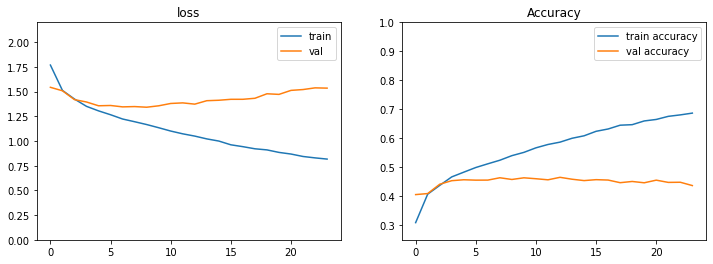

In [ ]:
plot_history(history_Cifar)

# CNN Model_Cifar --> Tiago v1

## Model Function

In [5]:
def initialize_compile_model(opt,l_rate=0.001):
    model = models.Sequential()

    model.add(Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=(X_train.shape[1], X_train.shape[2], 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.1))

    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.1))

    model.add(Conv2D(64, (2, 2), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.1))

    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    
    # Flatten and Dense Layers
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(25, activation='relu'))
    model.add(Dropout(0.1))

    # Output Layer
    model.add(Dense(y_train_cat.shape[1], activation='softmax'))
    
    # Compilation
    model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])
    return model

## Fitting

In [ ]:
seed(1)
set_seed(1)

es = EarlyStopping(patience=5,restore_best_weights=True)

opt = Adam()
model_Cifar = initialize_compile_model(opt = opt)

history_Cifar = model_Cifar.fit(X_train, y_train_cat, 
                                validation_split=0.25,
                                callbacks=[es],
                                epochs=5, 
                                batch_size=16,
                                shuffle=False) # Reduce to 16 for less overfitting

print(f'Score : {model_Cifar.evaluate(X_test, y_test_cat, verbose=0)[1]}')

Epoch 1/5
  5/929 [..............................] - ETA: 7:29:43 - loss: 2.0711 - accuracy: 0.1500

In [ ]:
#model_Cifar.predict(X_test)[0]

In [ ]:
plot_history(history_Cifar)

# CNN Model_Cifar --> Tiago v2


## Model Function 1

In [22]:
def initialize_compile_model(a,opt,l_rate=0.001):
    model = models.Sequential()

    model.add(Conv2D(50+a, (2, 2), activation='relu', padding='same', input_shape=(X_train.shape[1], X_train.shape[2], 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.1))

    model.add(Conv2D(100+a, (2, 2), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.1))

    model.add(Conv2D(200+a, (2, 2), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.1))
    
    # Flatten and Dense Layers
    model.add(Flatten())
    model.add(Dense(50+a, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(25, activation='relu'))
    model.add(Dropout(0.3))
    
    # Output Layer
    model.add(Dense(y_train_cat.shape[1], activation='softmax'))
    
    # Compilation
    model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])
    return model

## Model Function Looping values

In [33]:
def initialize_compile_model(a,initializer,opt,l_rate=0.001):
    model = models.Sequential()

    model.add(Conv2D(35, (2, 2), activation='relu', padding='same',kernel_initializer = initializer, bias_initializer=initializers.Constant(0.1), input_shape=(X_train.shape[1], X_train.shape[2], 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.1))

    model.add(Conv2D(70, (2, 2), activation='relu', padding='same',kernel_initializer = initializer, bias_initializer=initializers.Constant(0.1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.1))

    model.add(Conv2D(140, (2, 2), activation='relu', padding='same',kernel_initializer = initializer, bias_initializer=initializers.Constant(0.1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.1))
    
    # Flatten and Dense Layers
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(45, activation='relu'))
    model.add(Dropout(0.3))
    
    # Output Layer
    model.add(Dense(y_train_cat.shape[1], activation='softmax'))
    
    # Compilation
    model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])
    return model

## Fitting

In [73]:
from keras.initializers import GlorotUniform,HeUniform

In [74]:
es = EarlyStopping(patience=5,restore_best_weights=True)

opt = RMSprop()
#opt = optimizers.Adam(learning_rate=l_rate)
#opt = optimizers.RMSprop()
initializer = HeUniform()

neurons = [35]#,80,100,150]

for i in neurons:
  model_Cifar = initialize_compile_model(a=i,initializer=initializer,opt = opt)

  history_Cifar = model_Cifar.fit(X_train, y_train_cat, 
                                  validation_split=0.2,
                                  callbacks=[es],
                                  epochs=100, 
                                  batch_size=32) # Reduce t o 16 for less overfitting

  print(f'Score {i}: {model_Cifar.evaluate(X_test, y_test_cat, verbose=0)[1]}')

Epoch 1/100
496/496 [==============================] - 253s 509ms/step - loss: 1.8457 - accuracy: 0.3282 - val_loss: 1.6527 - val_accuracy: 0.3504
Epoch 2/100
496/496 [==============================] - 250s 504ms/step - loss: 1.5167 - accuracy: 0.4093 - val_loss: 1.5386 - val_accuracy: 0.3948
Epoch 3/100
496/496 [==============================] - 252s 508ms/step - loss: 1.4249 - accuracy: 0.4453 - val_loss: 1.5456 - val_accuracy: 0.3943
Epoch 4/100
496/496 [==============================] - 252s 507ms/step - loss: 1.3557 - accuracy: 0.4778 - val_loss: 1.4915 - val_accuracy: 0.3989
Epoch 5/100
496/496 [==============================] - 251s 507ms/step - loss: 1.2933 - accuracy: 0.5023 - val_loss: 1.4862 - val_accuracy: 0.4352
Epoch 6/100
496/496 [==============================] - 251s 507ms/step - loss: 1.2386 - accuracy: 0.5236 - val_loss: 1.4848 - val_accuracy: 0.4183
Epoch 7/100
496/496 [==============================] - 251s 506ms/step - loss: 1.1970 - accuracy: 0.5392 - val_loss: 1

In [22]:
#model_Cifar.predict(X_test)[0]

(<matplotlib.axes._subplots.AxesSubplot at 0x7f5eab867450>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f5ea9054690>)

<Figure size 1080x360 with 0 Axes>

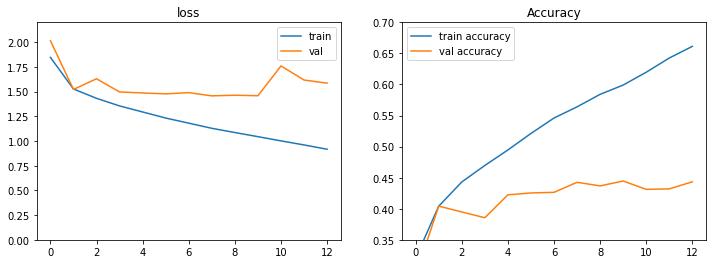

In [27]:
plot_history(history_Cifar) #0.5029

# Data Augmentation

In [17]:
datagen = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=(0.8, 1.2),
    ) 

datagen.fit(X_train)

In [18]:
X_augmented_iterator = datagen.flow(X_train, seed=1, shuffle=False, batch_size=1)

In [21]:
X_tr = X_train[:16862]
y_tr = y_train_cat[:16862]
X_val = X_train[16862:]
y_val = y_train_cat[16862:]

train_flow = datagen.flow(X_tr, y_tr, batch_size=64)

In [39]:
seed(1)
set_seed(1)

opt = Adam()
#initializer = HeUniform()
#initializer = GlorotUniform()

model_Cifar_aug = initialize_compile_model(opt = opt,l_rate=0.001)

es = EarlyStopping(patience=5,restore_best_weights=True)

X_tr = X_train[:16862]
y_tr = y_train_cat[:16862]
X_val = X_train[16862:]
y_val = y_train_cat[16862:]
train_flow = datagen.flow(X_tr, y_tr, batch_size=64)

history_Cifar_aug = model_Cifar_aug.fit(train_flow, 
                                validation_data=(X_val, y_val),
                                callbacks=[es],
                                epochs=100, 
                                batch_size=32,
                                shuffle=False)

print(f'Score: {model_Cifar_aug.evaluate(X_test, y_test_cat, verbose=0)[1]}')

Epoch 1/100
264/264 [==============================] - 189s 673ms/step - loss: 2.1305 - accuracy: 0.1893 - val_loss: 1.9807 - val_accuracy: 0.2647
Epoch 2/100
264/264 [==============================] - 398s 2s/step - loss: 1.9393 - accuracy: 0.2436 - val_loss: 1.8036 - val_accuracy: 0.3119
Epoch 3/100
264/264 [==============================] - 253s 962ms/step - loss: 1.8770 - accuracy: 0.2711 - val_loss: 1.7465 - val_accuracy: 0.3588
Epoch 4/100
264/264 [==============================] - 115s 431ms/step - loss: 1.8276 - accuracy: 0.2871 - val_loss: 1.6736 - val_accuracy: 0.3761
Epoch 5/100
264/264 [==============================] - 123s 465ms/step - loss: 1.7770 - accuracy: 0.3035 - val_loss: 1.6948 - val_accuracy: 0.3405
Epoch 6/100
264/264 [==============================] - 102s 388ms/step - loss: 1.7528 - accuracy: 0.3113 - val_loss: 1.6087 - val_accuracy: 0.3812
Epoch 7/100
264/264 [==============================] - 95s 358ms/step - loss: 1.7206 - accuracy: 0.3214 - val_loss: 1.584

KeyboardInterrupt: 

(<AxesSubplot:title={'center':'loss'}>,
 <AxesSubplot:title={'center':'Accuracy'}>)

<Figure size 1080x360 with 0 Axes>

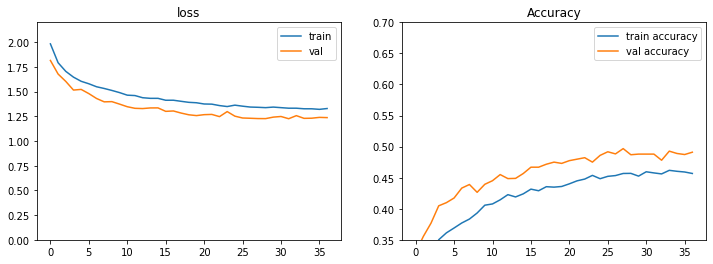

In [31]:
plot_history(history_Cifar_aug)

## Testing the Data Augmentation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


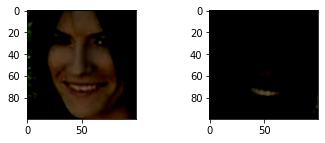

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


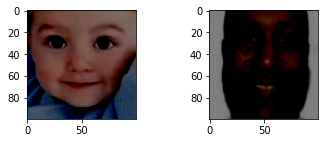

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


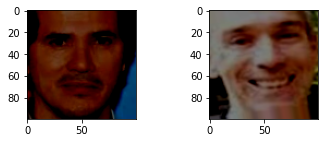

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


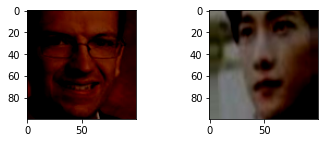

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


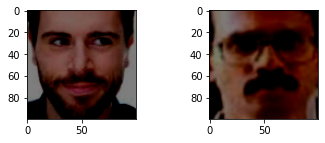

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


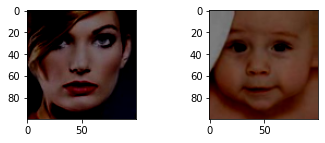

In [65]:
import numpy as np

for i, (raw_image, augmented_image) in enumerate(zip(X_train, X_augmented_iterator)):
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 2))
    ax1.imshow(raw_image)
    ax2.imshow(augmented_image[0])
    plt.show()
    
    if i > 4:
        break

## Dropout

## More Dropout maybe???

# Best Transfer Learning: CNN Model_Resnet50V2   37,5% (Not Good)

In [ ]:
from tensorflow.keras.applications import ResNet50V2

def load_model():
    model = ResNet50V2(
    include_top=False,
    weights="imagenet",
    input_shape=X_train[0].shape)
    return model

def set_nontrainable_layers(model):
    model.trainable = False
    return model 
    
def add_last_layers(model):
    base_model = set_nontrainable_layers(model)
    flatten_layer = layers.Flatten()
    dense_layer = layers.Dense(200, activation='relu')
    dropout_layer = layers.Dropout(0.2)
    prediction_layer = layers.Dense(y_train_cat.shape[1], activation='softmax')
    
    model = models.Sequential([
        base_model,
        dropout_layer,
        flatten_layer,
        dense_layer,
        dropout_layer,
        prediction_layer
    ])
    return model


def compile_model(model):
    
    opt = optimizers.Adam(learning_rate=0.001)
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    return model

def build_model():
    model = load_model()
    model = add_last_layers(model)
    model = compile_model(model)
    return model

In [ ]:
print(model_ResNet.summary())

In [ ]:
model_ResNet = build_model()

es = EarlyStopping(patience=10, verbose=1, restore_best_weights=True)

history_ResNet = model_ResNet.fit(X_train, y_train_cat, 
                    validation_split=0.3, 
                    callbacks=[es],
                    epochs=50, 
                    batch_size=32, 
                    verbose=1)

print(f'Score: {model_ResNet.evaluate(X_test, y_test_cat, verbose=0)[1]}')

plot_history(history_ResNet)

# Evaluation

In [ ]:
def convert_number(num):
    if num == 0:
        return '1-5'
    elif num == 1:
        return '6-19'
    elif num == 2:
        return '20-25'
    elif num == 3:
        return '26-26'
    elif num == 4:
        return '27-29'
    elif num == 5:
        return '30-34'
    elif num == 6:
        return '35-39'
    elif num == 7:
        return '40-49'
    elif num == 8:
        return '50-58'
    elif num == 9:
        return '59-80'


In [ ]:
def show_images_from_list_with_prediction(img_list,real,pred_list):
    n=int(len(img_list)/5) +1 
    f = plt.figure(figsize=(25,n*5))
    for i,img in enumerate(img_list):
        f.add_subplot(n, 5, i + 1)
        plt.title(f'Real: {int(real[i])} \n Prediction: {int(np.argsort(pred_list[i])[-1])}',
                  fontweight="bold",
                  fontsize=15)
        plt.imshow(img)
        f.tight_layout()

In [ ]:
X_test_show = (X_test + 0.5)

In [ ]:
pred_list_Cifar_aug = model_Cifar_aug.predict(X_test)

In [ ]:
pred_list_Cifar_aug[0:2]

array([[5.7163910e-04, 4.9745571e-02, 3.7823454e-01, 1.6937976e-01,
        2.1592721e-01, 1.3472047e-01, 4.6530019e-02, 4.8907869e-03],
       [6.7804198e-05, 4.9237946e-01, 2.1821359e-01, 1.4287877e-01,
        1.0076811e-01, 3.4192741e-02, 9.6745985e-03, 1.8248523e-03]],
      dtype=float32)

In [ ]:
np.argsort(pred_list_Cifar_aug[0:2])[:,-1]

array([2, 1])

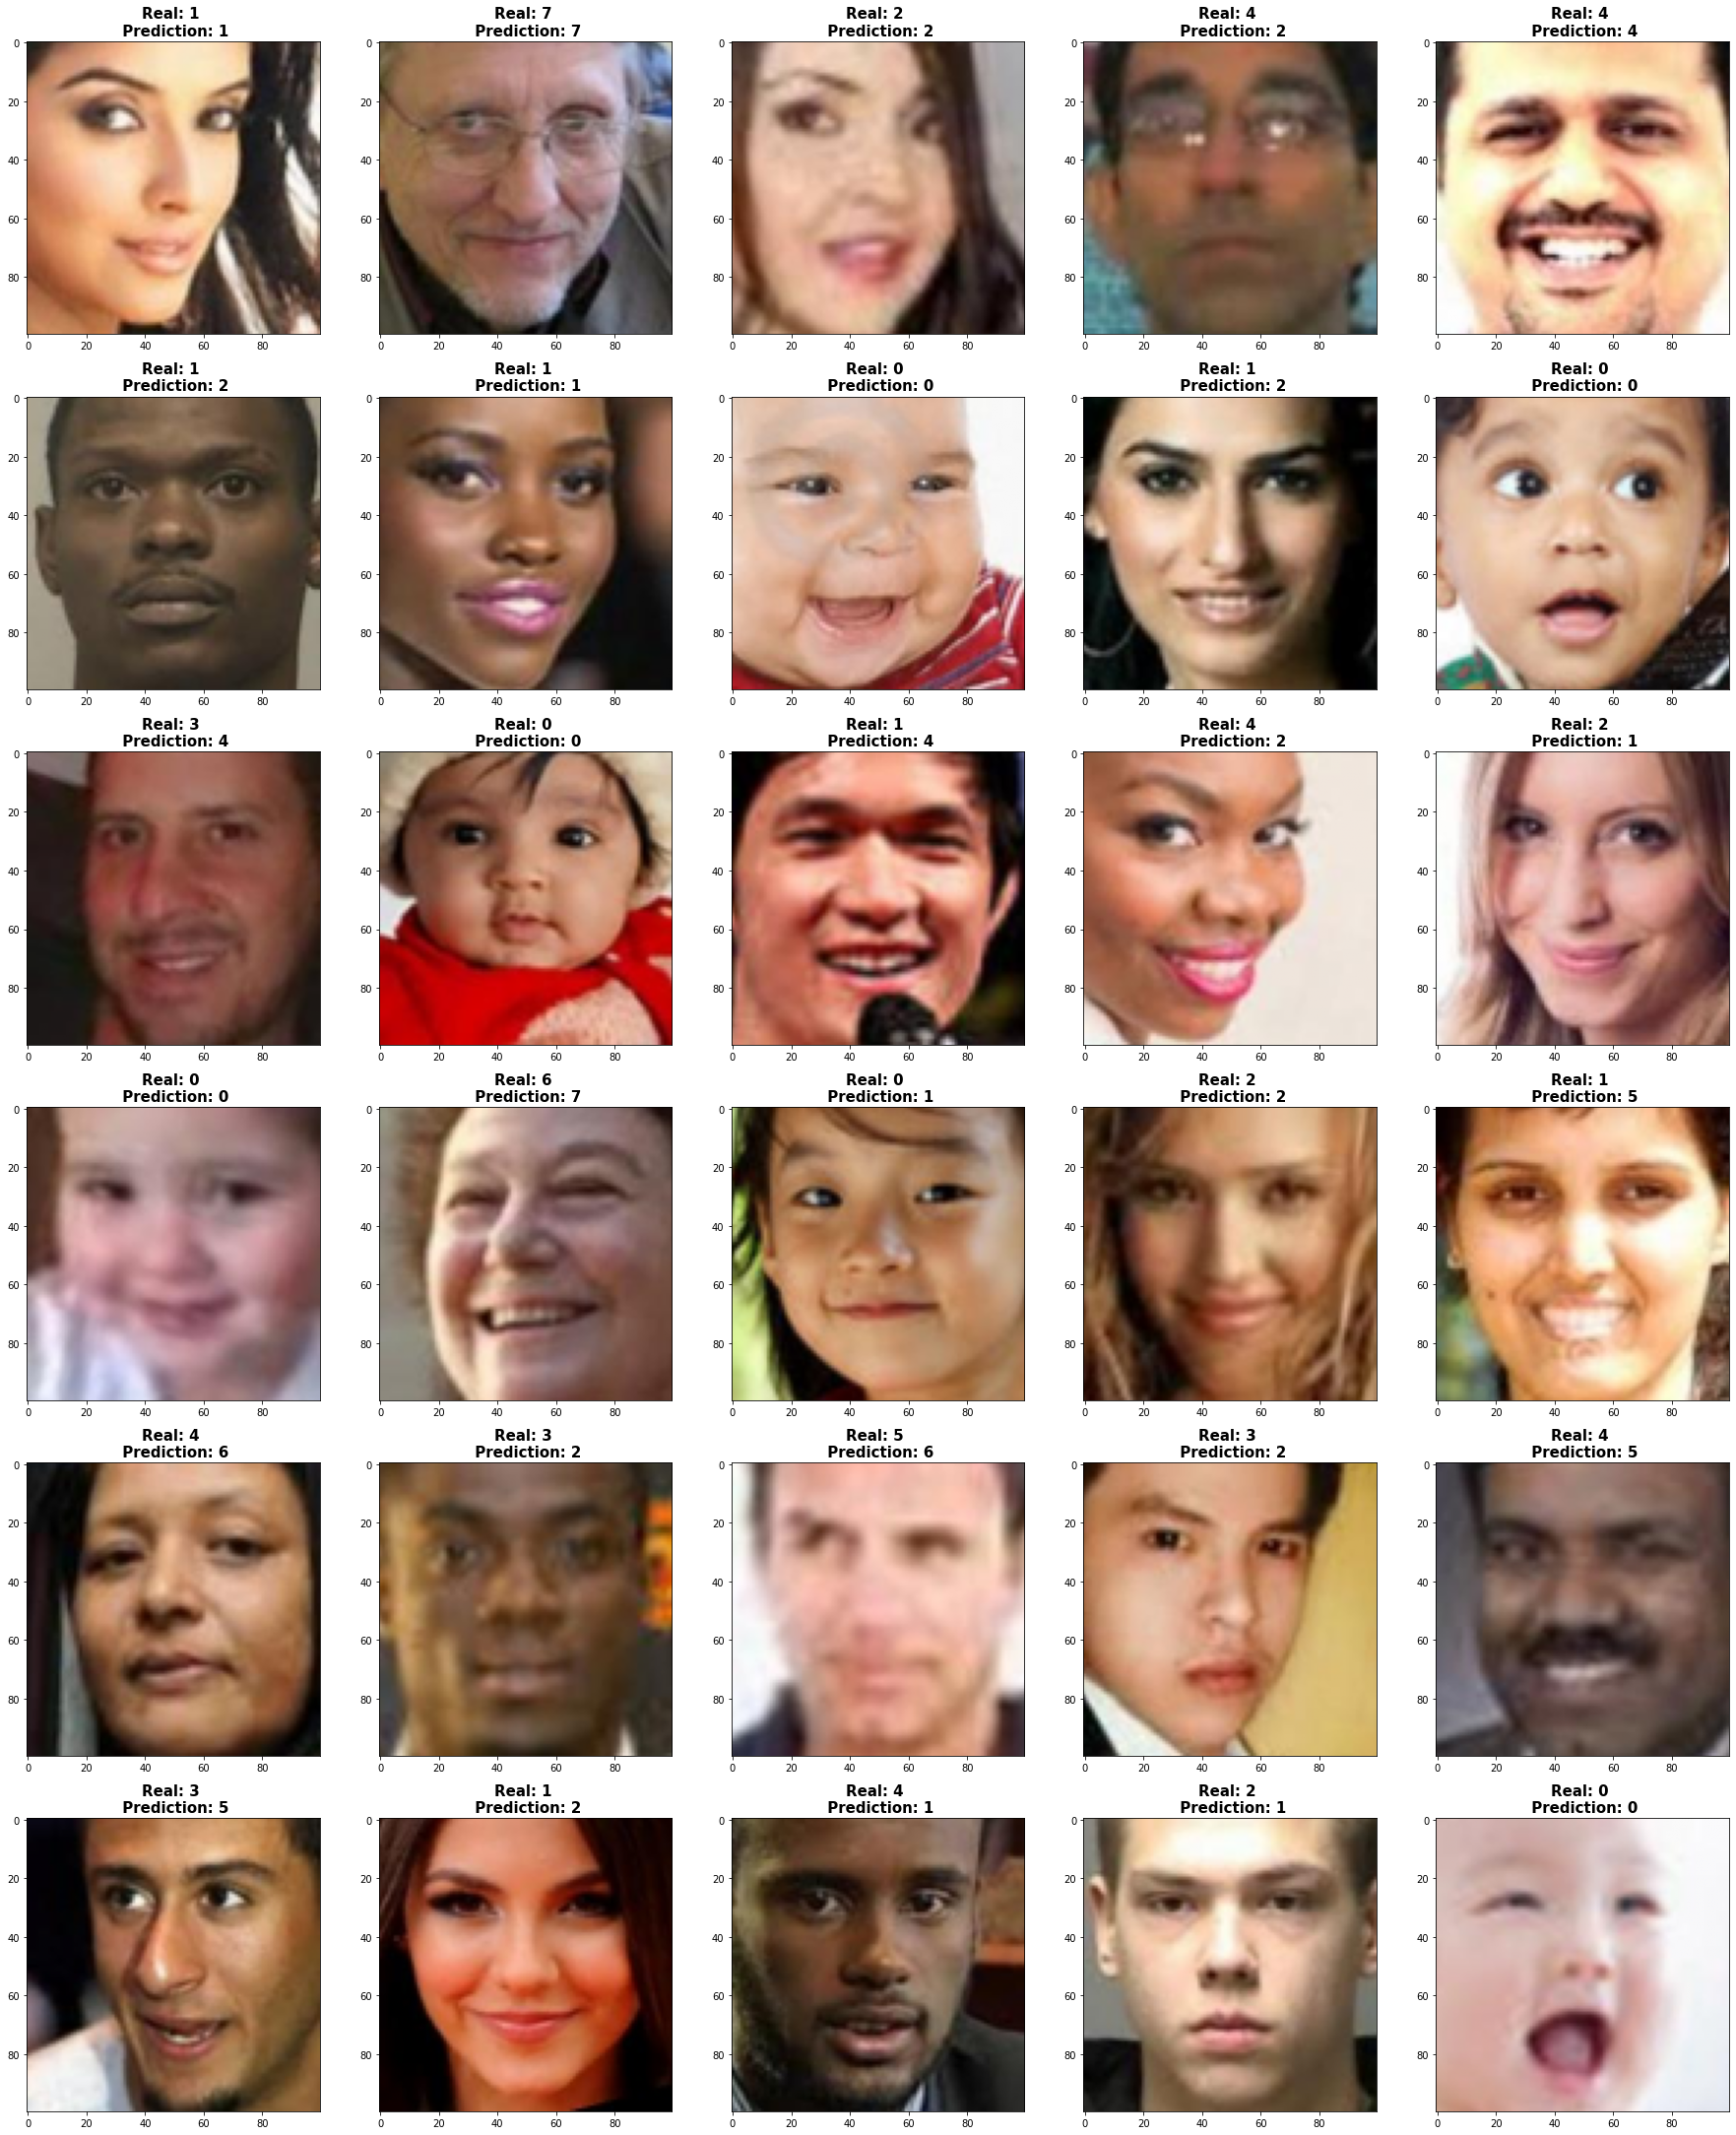

In [ ]:
show_images_from_list_with_prediction(X_test_show[40:70],y_test[40:70],pred_list_Cifar_aug[40:70])

# Visualisations

In [ ]:
f = plt.figure(figsize=(25,15))
bins_value=[1,4,8,24,27,33,46,56,81]
#bins_value = [0,5,10,15,20,25,27,30,35,40,45,50,55,60,65,70,75,80]
#bins_value = list(range(0,80,1))

#Age Histogram
f.add_subplot(211)
sns.histplot(data=img_df,x = 'age', bins=bins_value)
plt.title('Age Distribution',fontweight="bold",fontsize=30)
plt.xlabel('Age',fontsize=20)
plt.ylabel('Frequency',fontsize=20)
plt.xticks(bins_value, rotation = 25)

# Gender Histogram
f.add_subplot(223)
sns.histplot(img_df['gender'])
plt.title('Gender Distribution',fontweight="bold",fontsize=30)
plt.xlabel('Gender',fontsize=20)
plt.ylabel('Frequency',fontsize=20)

#Race Histogram
f.add_subplot(224)
sns.histplot(img_df['race'])
plt.title('Race Distribution',fontweight="bold",fontsize=30)
plt.xlabel('Race',fontsize=20)
plt.ylabel('Frequency',fontsize=20)
plt.xticks()

plt.show()

In [ ]:
pd.qcut(img_df['age'],8).value_counts().sort_index()

(0.999, 8.0]    2817
(8.0, 23.0]     2939
(23.0, 26.0]    3498
(26.0, 29.0]    1938
(29.0, 35.0]    3038
(35.0, 43.0]    2366
(43.0, 55.0]    2668
(55.0, 80.0]    2741
Name: age, dtype: int64

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
print("Confusion matrix:\n%s" % confusion_matrix(y_test, np.argsort(pred_list_Cifar_aug)[:,-1]))

Confusion matrix:
[[236  32   3   0   0   0   0   0]
 [ 17 189  97   2   9   6   1   1]
 [  2  76 217   1  31  12   6   1]
 [  1  31  95   1  39  14   6   0]
 [  1  30 127   1  60  44  29   1]
 [  0   9  44   4  34  57  67   7]
 [  0   5  13   2  25  34 125  63]
 [  0   3   3   0   2  10  68 207]]


In [ ]:
print("Classification matrix:\n%s" % classification_report(y_test, np.argsort(pred_list_Cifar_aug)[:,-1]))

Classification matrix:
              precision    recall  f1-score   support

           0       0.92      0.87      0.89       271
           1       0.50      0.59      0.54       322
           2       0.36      0.63      0.46       346
           3       0.09      0.01      0.01       187
           4       0.30      0.20      0.24       293
           5       0.32      0.26      0.29       222
           6       0.41      0.47      0.44       267
           7       0.74      0.71      0.72       293

    accuracy                           0.50      2201
   macro avg       0.46      0.47      0.45      2201
weighted avg       0.47      0.50      0.47      2201



In [ ]:
pd.DataFrame(y_test).value_counts().sort_index()

0    271
1    322
2    346
3    187
4    293
5    222
6    267
7    293
dtype: int64

In [ ]:
pd.DataFrame(y).value_counts()

age_group
2            3498
4            3038
1            2939
0            2817
7            2741
6            2668
5            2366
3            1938
dtype: int64